In [15]:
%pip install mesa==2.1.1
%pip install matplotlib
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

  Using cached Mesa-2.1.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached cookiecutter-2.6.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached solara-1.55.0-py3-none-any.whl.metadata (10 kB)
  Using cached binaryornot-0.4.4-py2.py3-none-any.whl.metadata (6.0 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached arrow-1.4.0-py3-none-any.whl.metadata (7.7 kB)
  Using cached rich-14.2.0-py3-none-any.whl.metadata (18 kB)
  Using cached solara_server-1.55.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached solara_ui-1.55.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached rich_click-1.9.4-py3-none-any.whl.metadata (8.7 kB)
  Using cached watchfiles-1.1.1-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
  Using 


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\aksel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\aksel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [50]:
class SimpsonAgentRandom(Agent):
    """
    Bombero con estrategia random:
    - Se mueve al azar (sin salirse del mapa)
    - Si intenta entrar a una puerta cerrada, la abre
    - Si pisa fuego o humo, lo apaga
    - Si pisa una víctima y no carga a nadie, la recoge
    - Si llega a la ambulancia cargando una víctima, la deja
    """
    def __init__(self, model):
        super().__init__(model)
        self.carrying_victim = False
        self.base_ap = 4

        self.victims_picked = 0
        self.victims_rescued = 0
        self.fires_extinguished = 0
        self.smokes_extinguished = 0
        self.doors_opened = 0
        self.action_points = 0 # Puntos de acción usados en total

    def get_available_actions(self, ap):
        actions = []
        x, y = self.pos

        positions_to_check = [self.pos] + list(
        self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        )

        for tx, ty in positions_to_check:
            if not (0 <= tx < self.model.grid.width and 0 <= ty < self.model.grid.height):
                continue
        
            val = self.model.env_grid[tx, ty]

            # Checar si hay fuego o humo para apagar y revisar los puntos de acción
            if val in (self.model.FIRE, self.model.SMOKE) and ap >= 1:
                actions.append({
                    "type": "extinguish",
                    "target": (tx, ty),
                })

        neighbors = self.model.grid.get_neighborhood((x, y), moore=True, include_center=False)

        # Checar si hay puertas cerradas alrededor para abrir
        if ap >= 1:
            for nx, ny in neighbors:
                if not (0 <= nx < self.model.grid.width and 0 <= ny < self.model.grid.height):
                    continue
                edge_type = self.model.edges.get(((x, y), (nx, ny)), "empty")
                if edge_type == "door_closed":
                    actions.append({
                        "type": "open_door",
                        "from": (x, y),
                        "to": (nx, ny),
                    })
        for nx, ny in neighbors:
            if not self.model.can_move((x, y), (nx, ny)):
                continue

            cell_value = self.model.env_grid[nx, ny]

            if cell_value == self.model.FIRE:
                continue

            if self.carrying_victim:
                move_cost = 2
            else:
                move_cost = 1

            if move_cost <= ap:
                actions.append({
                    "type": "move",
                    "to": (nx, ny),
                    "cost": move_cost,
                })

        return actions
        

    def execute_action(self, action, ap):
        if action["type"] == "extinguish":
            return self.execute_extinguish(action, ap)
        elif action["type"] == "open_door":
            return self.execute_open_door(action, ap)
        elif action["type"] == "move":
            return self.execute_move(action, ap)
        else:
            return ap
        
    def execute_extinguish(self, action, ap):
        tx, ty = action["target"]
        val = self.model.env_grid[tx, ty]

        if val not in (self.model.FIRE, self.model.SMOKE):
            return ap
    
        if val == self.model.SMOKE:
            cost = 1
            if cost > ap:
                return ap
            self.model.env_grid[tx, ty] = self.model.EMPTY
            self.smokes_extinguished += 1
        
        elif val == self.model.FIRE:
            cost = 2
            if ap >= 2:
                self.model.env_grid[tx, ty] = self.model.EMPTY
                self.fires_extinguished += 1
            elif ap >= 1:
                cost = 1
                self.model.env_grid[tx, ty] = self.model.SMOKE
                self.smokes_extinguished += 1
            else:
                return ap
        else:
            return ap
        
        self.action_points += cost
        return ap - cost

    def execute_open_door(self, action, ap):
        from_pos = action["from"]
        to_pos = action["to"]

        edge_type = self.model.edges.get((from_pos, to_pos), "empty")
        if edge_type != "door_closed":
            return ap
        
        self.model.set_edge(from_pos, to_pos, "door_open")
        self.doors_opened += 1
        self.action_points += 1
        return ap - 1
    
    def execute_move(self, action, ap):
        cost = action["cost"]
        if cost > ap:
            return ap
        
        nx, ny = action["to"]
        if not self.model.can_move(self.pos, (nx, ny)):
            return ap
        
        self.model.grid.move_agent(self, (nx, ny))
        self.action_points += cost
        return ap - cost
    
    def handle_victims(self):
        x,y = self.pos
        cell_value = self.model.env_grid[x, y]

        if cell_value == self.model.VICTIM and not self.carrying_victim:
            self.carrying_victim = True
            self.model.env_grid[x, y] = self.model.EMPTY
            self.victims_picked += 1

        elif cell_value == self.model.AMBULANCE and self.carrying_victim:
            self.carrying_victim = False
            self.victims_rescued += 1

    def step(self):
        ap = self.base_ap

        self.handle_victims()

        while ap > 0:
            available_actions = self.get_available_actions(ap)
            if not available_actions:
                break

            action = random.choice(available_actions)
            ap = self.execute_action(action, ap)

            self.handle_victims()


In [77]:
class SimpsonRandomModel(Model):
    EMPTY = 0
    FIRE = 1
    SMOKE = 2
    VICTIM = 6
    DOOR_CLOSED = 4
    DOOR_OPEN = 5
    AMBULANCE = 6
    FIREFIGHTER = 7 

    def __init__(
            self,
            width=10,
            height=10,
            num_firefighters=6,
            num_fires=8,
            num_smokes=8,
            num_victims=4,
            num_doors=8,
            num_walls=8,
            seed=None,
    ):
        super().__init__()
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
            self.random.seed(seed)

        self.width = width
        self.height = height

        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)

        self.env_grid = np.zeros((width, height), dtype=int)

        self.ambulance_pos = (0,0)
        self.env_grid[self.ambulance_pos] = self.AMBULANCE

        self._randomly_place_elements(num_fires, self.FIRE)
        self._randomly_place_elements(num_smokes, self.SMOKE)
        self._randomly_place_elements(num_victims, self.VICTIM)

        self.edges = {}
        self._init_edges_empty()
        self._randomly_place_edges(num_walls, "wall")
        self._randomly_place_edges(num_doors, "door_closed")

        for i in range(num_firefighters):
            self._add_firefighter(i)

        self.datacollector = DataCollector(
            model_reporters={
                "total_victims_picked": lambda m: sum(
                    a.victims_picked for a in m.schedule.agents
                ),
                "toatal_victims_rescued": lambda m: sum(
                    a.victims_rescued for a in m.schedule.agents
                ),
                "total_fires_extinguished": lambda m: sum(
                    a.fires_extinguished for a in m.schedule.agents
                ),
                "total_smokes_extinguished": lambda m: sum(
                    a.smokes_extinguished for a in m.schedule.agents
                ),
                "total_doors_opened": lambda m: sum(
                    a.doors_opened for a in m.schedule.agents
                ),
                "total_action_points": lambda m: sum(
                    a.action_points for a in m.schedule.agents
                ),
            },
            agent_reporters={
                "victims_picked": "victims_picked",
                "victims_rescued": "victims_rescued",
                "fires_extinguished": "fires_extinguished",
                "smokes_extinguished": "smokes_extinguished",
                "doors_opened": "doors_opened",
                "action_points": "action_points",
            },
        )

    def set_edge(self, pos_a, pos_b, edge_type):
        self.edges[(pos_a, pos_b)] = edge_type
        self.edges[(pos_b, pos_a)] = edge_type

    def _init_edges_empty(self):
        for x in range(self.width):
            for y in range(self.height):
                from_pos = (x, y)  
                neighbors = [
                    (x + 1, y),
                    (x - 1, y),
                    (x, y + 1),
                    (x, y - 1),
                ]
                for nx, ny in neighbors:
                    if 0 <= nx < self.width and 0 <= ny < self.height:
                        to_pos = (nx, ny)
                        if (from_pos, to_pos) not in self.edges:
                            self.set_edge(from_pos, to_pos, "empty")

    def _randomly_place_edges(self, count, edge_type):
        all_pairs = []
        for x in range(self.width):
            for y in range(self.height):
                from_pos = (x, y)
                neighbors = [
                    (x + 1, y),
                    (x, y + 1),
                ]
                for nx, ny in neighbors:
                    if 0 <= nx < self.width and 0 <= ny < self.height:
                        to_pos = (nx, ny)
                        all_pairs.append((from_pos, to_pos))
        
        self.random.shuffle(all_pairs)

        placed = 0 
        for from_pos, to_pos in all_pairs:
            if placed >= count:
                break
            current = self.edges.get((from_pos, to_pos), "empty")
            if current == "empty":
                self.set_edge(from_pos, to_pos, edge_type)
                placed += 1 

    def can_move(self, from_pos, to_pos):   
        x, y = to_pos

        if x < 0 or x >= self.width or y < 0 or y >= self.height:
            return False
        
        edge_type = self.edges.get((from_pos, to_pos), "empty")

        if edge_type in ("wall", "door_closed"):
            return False
        
        return True
    
    def _randomly_place_elements(self, count, code):
        all_cells = [(x, y) for x in range(self.width) for y in range(self.height)]
        self.random.shuffle(all_cells)

        placed = 0
        for x, y in all_cells:
            if placed >= count:
                break
            if self.env_grid[x, y] == self.EMPTY:
                self.env_grid[x, y] = code
                placed += 1
    
    def _add_firefighter(self, i):
        all_cells = [(x, y) for x in range(self.width) for y in range(self.height)]
        self.random.shuffle(all_cells)
        for x, y in all_cells:
            if self.env_grid[x, y] == self.EMPTY and self.grid.is_cell_empty((x, y)):
                agent = SimpsonAgentRandom(self)
                self.grid.place_agent(agent, (x, y))
                self.schedule.add(agent)
                break

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

    def get_visual_grid(self):
        vis_grid = self.env_grid.copy()
        for agent in self.schedule.agents:
            x, y = agent.pos
            vis_grid[x, y] = self.FIREFIGHTER
        return vis_grid
    

In [ ]:
# --- Animación con paredes/puertas (edges) + bomberos como puntos (scatter) ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from IPython.display import HTML

# Fallback por si no tienes colors/cmap definidos en tu notebook
try:
    cmap
    colors
except NameError:
    from matplotlib.colors import ListedColormap
    colors = ["white","red","orange","blue","black","gray","green","magenta"]
    cmap = ListedColormap(colors)

def _agents_list(model):
    # Mesa 3.x: model.agents; versiones viejas: schedule.agents
    if hasattr(model, "agents"):
        return list(model.agents)
    if hasattr(model, "schedule"):
        return list(model.schedule.agents)
    return []

def edge_segments(model):
    """
    Convierte model.edges (entre celdas) a segmentos de línea para dibujar encima del grid.
    Retorna: (walls, doors_closed, doors_open) como listas de segmentos.
    Cada segmento: [(x1,y1),(x2,y2)]
    """
    walls, doors_closed, doors_open = [], [], []

    for x in range(model.width):
        for y in range(model.height):
            # borde entre (x,y) y (x+1,y) => línea vertical en x+0.5
            if x + 1 < model.width:
                t = model.edges.get(((x, y), (x + 1, y)), "empty")
                seg = [(x + 0.5, y - 0.5), (x + 0.5, y + 0.5)]
                if t == "wall": walls.append(seg)
                elif t == "door_closed": doors_closed.append(seg)
                elif t == "door_open": doors_open.append(seg)

            # borde entre (x,y) y (x,y+1) => línea horizontal en y+0.5
            if y + 1 < model.height:
                t = model.edges.get(((x, y), (x, y + 1)), "empty")
                seg = [(x - 0.5, y + 0.5), (x + 0.5, y + 0.5)]
                if t == "wall": walls.append(seg)
                elif t == "door_closed": doors_closed.append(seg)
                elif t == "door_open": doors_open.append(seg)

    return walls, doors_closed, doors_open

def animate_with_edges(model, steps=80, interval=300, show_open_doors=True):
    """
    - Fondo: env_grid
    - Encima: bomberos como scatter
    - Encima: paredes/puertas (edges) como LineCollections
    Devuelve HTML listo para mostrar en Jupyter.
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Fondo (usamos .T para mantener tu orientación)
    bg = ax.imshow(model.env_grid.T, cmap=cmap, vmin=0, vmax=len(colors) - 1, origin="upper")

    # Bomberos (puntos) - color amarillo brillante
    sc = ax.scatter([], [], s=140, c='yellow', marker='o', edgecolors='black', linewidths=1.5)

    # Límites alineados a bordes de celdas
    ax.set_xlim(-0.5, model.width - 0.5)
    ax.set_ylim(model.height - 0.5, -0.5)  # origen arriba (coincide con origin="upper")
    ax.set_aspect("equal")

    # Ticks principales (solo labels)
    ax.set_xticks(range(model.width))
    ax.set_yticks(range(model.height))

    # Ticks menores en los bordes de celda (-0.5, 0.5, 1.5, ...)
    ax.set_xticks(np.arange(-0.5, model.width, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, model.height, 1), minor=True)

    # Grid REAL sobre bordes de celdas (minor)
    ax.grid(which="minor", linewidth=0.7)
    ax.grid(which="major", linewidth=0)   # quita líneas en centros

    # Colecciones de líneas (paredes/puertas) con colores visibles
    walls, dc, do = edge_segments(model)

    lc_w  = LineCollection(walls, colors="black", linewidths=3)          # paredes
    lc_dc = LineCollection(dc,    colors="#00E5FF", linewidths=3)        # puertas cerradas (cyan fuerte)
    ax.add_collection(lc_w)
    ax.add_collection(lc_dc)

    lc_do = None
    if show_open_doors:
        lc_do = LineCollection(do, colors="#FFD400", linewidths=2, linestyles="dashed")  # puertas abiertas (amarillo)
        ax.add_collection(lc_do)

    ax.set_title("Simpson Flashpoint — paredes/puertas + agentes")

    def update(frame):
        model.step()

        # Actualiza fondo
        bg.set_data(model.env_grid.T)

        # Actualiza bomberos (posiciones)
        agents = _agents_list(model)
        xs = [a.pos[0] for a in agents]
        ys = [a.pos[1] for a in agents]
        sc.set_offsets(np.c_[xs, ys] if len(xs) else np.empty((0, 2)))

        # Actualiza puertas/paredes (por si cambian al abrir puerta)
        walls, dc, do = edge_segments(model)
        lc_w.set_segments(walls)
        lc_dc.set_segments(dc)
        if lc_do is not None:
            lc_do.set_segments(do)

        ax.set_title(f"Paso {frame + 1}")
        return []

    anim = animation.FuncAnimation(fig, update, frames=steps, interval=interval, blit=False)
    plt.close(fig)
    return HTML(anim.to_jshtml())

# --- USO ---
# model = SimpsonRandomModel(seed=42)
# animate_with_edges(model, steps=80, interval=250, show_open_doors=True)


In [79]:
model = SimpsonRandomModel(seed=43)
animate_with_edges(model, steps=80, interval=250, show_open_doors=True)


ESTADÍSTICAS FINALES DEL MODELO
Total víctimas recogidas: 4
Total víctimas rescatadas: 2
Total fuegos apagados: 6
Total humos apagados: 12
Total puertas abiertas: 8
Total puntos de acción usados: 1940

ESTADÍSTICAS POR AGENTE (al final de la simulación)

Agente 1:
  Víctimas recogidas: 1
  Víctimas rescatadas: 1
  Fuegos apagados: 0
  Humos apagados: 1
  Puertas abiertas: 1
  Puntos de acción usados: 323

Agente 2:
  Víctimas recogidas: 1
  Víctimas rescatadas: 0
  Fuegos apagados: 0
  Humos apagados: 0
  Puertas abiertas: 3
  Puntos de acción usados: 322

Agente 3:
  Víctimas recogidas: 1
  Víctimas rescatadas: 1
  Fuegos apagados: 2
  Humos apagados: 1
  Puertas abiertas: 1
  Puntos de acción usados: 324

Agente 4:
  Víctimas recogidas: 0
  Víctimas rescatadas: 0
  Fuegos apagados: 2
  Humos apagados: 4
  Puertas abiertas: 2
  Puntos de acción usados: 324

Agente 5:
  Víctimas recogidas: 1
  Víctimas rescatadas: 0
  Fuegos apagados: 2
  Humos apagados: 4
  Puertas abiertas: 1
  Punto

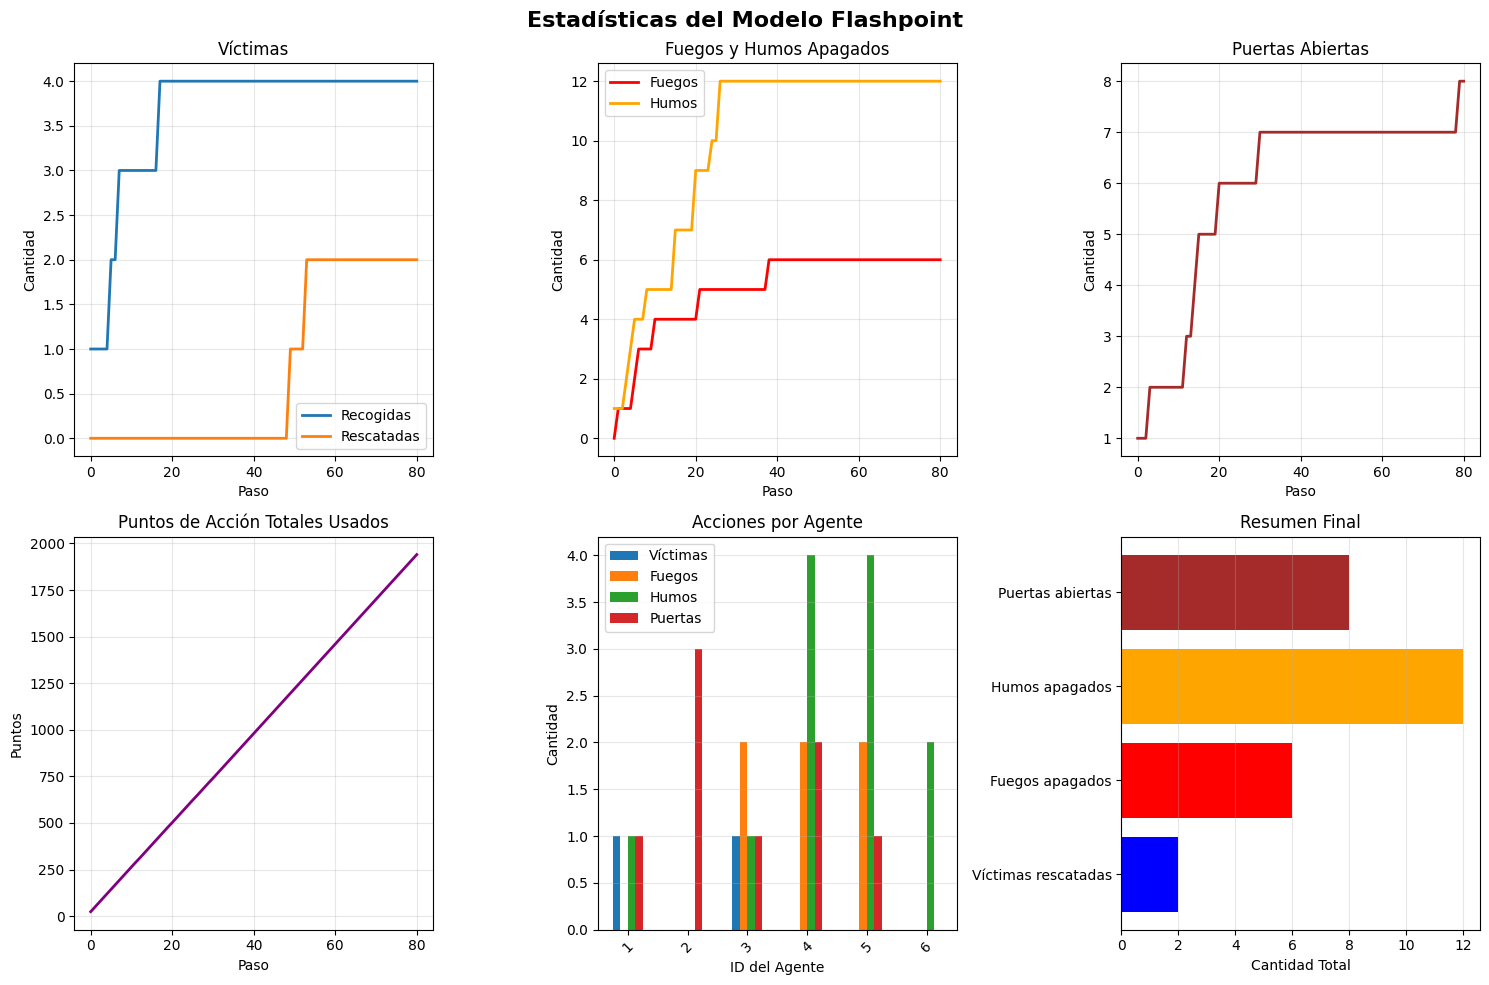

In [76]:
# Obtener datos recolectados
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

# Mostrar estadísticas finales del modelo
print("=" * 60)
print("ESTADÍSTICAS FINALES DEL MODELO")
print("=" * 60)
print(f"Total víctimas recogidas: {model_df['total_victims_picked'].iloc[-1]}")
print(f"Total víctimas rescatadas: {model_df['toatal_victims_rescued'].iloc[-1]}")
print(f"Total fuegos apagados: {model_df['total_fires_extinguished'].iloc[-1]}")
print(f"Total humos apagados: {model_df['total_smokes_extinguished'].iloc[-1]}")
print(f"Total puertas abiertas: {model_df['total_doors_opened'].iloc[-1]}")
print(f"Total puntos de acción usados: {model_df['total_action_points'].iloc[-1]}")
print()

# Mostrar estadísticas por agente
print("=" * 60)
print("ESTADÍSTICAS POR AGENTE (al final de la simulación)")
print("=" * 60)

# Obtener el último paso de cada agente
last_step = agent_df.index.get_level_values('Step').max()
final_agents = agent_df.xs(last_step, level='Step')

for agent_id, row in final_agents.iterrows():
    print(f"\nAgente {agent_id}:")
    print(f"  Víctimas recogidas: {row['victims_picked']}")
    print(f"  Víctimas rescatadas: {row['victims_rescued']}")
    print(f"  Fuegos apagados: {row['fires_extinguished']}")
    print(f"  Humos apagados: {row['smokes_extinguished']}")
    print(f"  Puertas abiertas: {row['doors_opened']}")
    print(f"  Puntos de acción usados: {row['action_points']}")

# Crear gráficas
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Estadísticas del Modelo Flashpoint', fontsize=16, fontweight='bold')

# Gráfica 1: Víctimas a lo largo del tiempo
axes[0, 0].plot(model_df.index, model_df['total_victims_picked'], label='Recogidas', linewidth=2)
axes[0, 0].plot(model_df.index, model_df['toatal_victims_rescued'], label='Rescatadas', linewidth=2)
axes[0, 0].set_xlabel('Paso')
axes[0, 0].set_ylabel('Cantidad')
axes[0, 0].set_title('Víctimas')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gráfica 2: Fuegos y humos apagados
axes[0, 1].plot(model_df.index, model_df['total_fires_extinguished'], label='Fuegos', linewidth=2, color='red')
axes[0, 1].plot(model_df.index, model_df['total_smokes_extinguished'], label='Humos', linewidth=2, color='orange')
axes[0, 1].set_xlabel('Paso')
axes[0, 1].set_ylabel('Cantidad')
axes[0, 1].set_title('Fuegos y Humos Apagados')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gráfica 3: Puertas abiertas
axes[0, 2].plot(model_df.index, model_df['total_doors_opened'], linewidth=2, color='brown')
axes[0, 2].set_xlabel('Paso')
axes[0, 2].set_ylabel('Cantidad')
axes[0, 2].set_title('Puertas Abiertas')
axes[0, 2].grid(True, alpha=0.3)

# Gráfica 4: Puntos de acción totales
axes[1, 0].plot(model_df.index, model_df['total_action_points'], linewidth=2, color='purple')
axes[1, 0].set_xlabel('Paso')
axes[1, 0].set_ylabel('Puntos')
axes[1, 0].set_title('Puntos de Acción Totales Usados')
axes[1, 0].grid(True, alpha=0.3)

# Gráfica 5: Comparación de acciones por agente (barras)
actions_by_agent = final_agents[['victims_rescued', 'fires_extinguished', 'smokes_extinguished', 'doors_opened']]
actions_by_agent.plot(kind='bar', ax=axes[1, 1], rot=45)
axes[1, 1].set_xlabel('ID del Agente')
axes[1, 1].set_ylabel('Cantidad')
axes[1, 1].set_title('Acciones por Agente')
axes[1, 1].legend(['Víctimas', 'Fuegos', 'Humos', 'Puertas'], loc='upper left')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Gráfica 6: Resumen final (barras horizontales)
final_stats = {
    'Víctimas rescatadas': model_df['toatal_victims_rescued'].iloc[-1],
    'Fuegos apagados': model_df['total_fires_extinguished'].iloc[-1],
    'Humos apagados': model_df['total_smokes_extinguished'].iloc[-1],
    'Puertas abiertas': model_df['total_doors_opened'].iloc[-1]
}
axes[1, 2].barh(list(final_stats.keys()), list(final_stats.values()), 
                color=['blue', 'red', 'orange', 'brown'])
axes[1, 2].set_xlabel('Cantidad Total')
axes[1, 2].set_title('Resumen Final')
axes[1, 2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [33]:
import mesa
print(mesa.__version__)


3.3.1
